In [1]:
import pandas as pd
import os

# Read the x and y data from CSV files
#os.chdir("/Users/alrz-/Library/CloudStorage/OneDrive-Personal/Backup/Yield Curve Pricing/Data")
os.chdir(f"{os.getcwd()}\data")

raw_x = pd.read_csv("x.csv", index_col=0)
raw_initial_y = pd.read_csv("y.csv", index_col=0)

# Calculate the growth rate for each column in raw_y
raw_y = raw_initial_y.pct_change()

#replace Nan with 0 for raw_y
raw_y = raw_y.fillna(0)
raw_x.index=raw_y.index

print(f"the number of predictors are: {len(raw_x.columns)}")

the number of predictors are: 383


In [2]:
dep_list=[
 "2-year yield",
 "3-year yield",
 "5-year yield",
"7-year yield",
"10-year yield",
"long-term yield",
"1-month yield",
"2-month yield",
"3-month yield",
"6-month yield",
"1-year yield"
]

sort_list=[
    "1-month yield",
    "2-month yield",
    "3-month yield",
    "6-month yield",
    "1-year yield",
    "2-year yield",
    "3-year yield",
    "5-year yield",
    "7-year yield",
    "10-year yield",
    "long-term yield"
]


In [3]:
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Create a folder to save the plots
folder_path = "results/plots correlation"
os.makedirs(folder_path, exist_ok=True)

# Plot autocorrelation lags for each column in raw_y
num_lags = 5

for col in raw_initial_y.columns:
    fig, ax = plt.subplots(figsize=(6, 4))
    sm.graphics.tsa.plot_acf(raw_initial_y[col], lags=num_lags, ax=ax)
    ax.set_xlabel('Lag')
    ax.set_ylabel('Autocorrelation')
    ax.set_xlim(0, num_lags)  # Limit the number of lags
    ax.set_title("")
    
    # Save the plot in the folder
    plot_path = os.path.join(folder_path, f"{col}_autocorrelation.jpeg")
    plt.savefig(plot_path)
    plt.close(fig)
    #plt.show()


In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.preprocessing import MinMaxScaler

class DataNormalizer:
    def __init__(self):
        self.scaler = MinMaxScaler()
    
    def normalize_dataframe(self, dataframe):
        normalized_dataframe = pd.DataFrame(self.scaler.fit_transform(dataframe), columns=dataframe.columns, index=dataframe.index)
        return normalized_dataframe
    
    def denormalize_dataframe(self, normalized_dataframe):
        denormalized_dataframe = pd.DataFrame(self.scaler.inverse_transform(normalized_dataframe), columns=normalized_dataframe.columns, index=normalized_dataframe.index)
        return denormalized_dataframe

# Usage:
Xnormalizer = DataNormalizer()
Ynormalizer = DataNormalizer()

# Normalize data
x_normalized = Xnormalizer.normalize_dataframe(raw_x)
y_normalized = Ynormalizer.normalize_dataframe(raw_y)

# Denormalize data
x_denormalized = Xnormalizer.denormalize_dataframe(x_normalized)
y_denormalized = Ynormalizer.denormalize_dataframe(y_normalized)

In [5]:
# Print the shapes of the resulting sets
print("Cut data shapes:")
print("x cut:", raw_x.shape)
print("y cut:", raw_y.shape)

# Set the percentages for training, validation, and test sets
train_percentage = 0.72
val_percentage = 0.08
test_percentage = 0.2

# Calculate the sizes of each set
total_samples = len(raw_x)
train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

# Split the data into training, validation, and test sets
x_train = raw_x[:train_size]
x_val = raw_x[train_size:train_size+val_size]
x_test = raw_x[train_size+val_size:]

y_train = raw_y[:train_size]
y_val = raw_y[train_size:train_size+val_size]
y_test = raw_y[train_size+val_size:]

# Print the shapes of the resulting sets
print("Training set shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("\nValidation set shapes:")
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("\nTest set shapes:")
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)

Cut data shapes:
x cut: (240, 383)
y cut: (240, 11)
Training set shapes:
x_train: (172, 383)
y_train: (172, 11)

Validation set shapes:
x_val: (19, 383)
y_val: (19, 11)

Test set shapes:
x_test: (49, 383)
y_test: (49, 11)


In [7]:
import pandas as pd

all_mean = raw_initial_y.mean()
all_std = raw_initial_y.std()

train_mean = raw_initial_y[:train_size].mean()
train_std = raw_initial_y[:train_size].std()

val_mean = raw_initial_y[train_size:train_size+val_size].mean()
val_std = raw_initial_y[train_size:train_size+val_size].std()

test_mean = raw_initial_y[train_size+val_size:].mean()
test_std = raw_initial_y[train_size+val_size:].std()

data = {
    'all_mean': all_mean,
    'all_std': all_std,
    'train_mean': train_mean,
    'train_std': train_std,
    'val_mean': val_mean,
    'val_std': val_std,
    'test_mean': test_mean,
    'test_std': test_std
}

df = pd.DataFrame(data)

df = df.round(decimals=2)
df.index=dep_list

df = df.reindex(sort_list)

df.to_csv("results/summary_y.csv")

In [8]:
import numpy as np

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2, axis=0)

def mae(y_true, y_pred):
    return np.mean(np.abs(y_true - y_pred), axis=0)

def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true), axis=0) * 100

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2, axis=0))

In [9]:
## Plotting the data
num_x_values = 7  # Adjust the number of x values as needed
x_ticks = raw_y.index[::len(raw_y.index) // num_x_values]
'''
for col in columns:
    plt.figure(figsize=(2, 1.5))  # Adjust the figsize parameter to make the plots smaller
    plt.plot(y_train.index, y_train[col], label=f'y_train - {col}')
    plt.plot(y_val.index, y_val[col], label=f'y_val - {col}')
    plt.plot(y_test.index, y_test[col], label=f'y_test - {col}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(f'Plot of {col} in y_train, y_val, and y_test')
    plt.xticks(x_ticks,rotation=45) 
    plt.legend()
    plt.show()
'''

"\nfor col in columns:\n    plt.figure(figsize=(2, 1.5))  # Adjust the figsize parameter to make the plots smaller\n    plt.plot(y_train.index, y_train[col], label=f'y_train - {col}')\n    plt.plot(y_val.index, y_val[col], label=f'y_val - {col}')\n    plt.plot(y_test.index, y_test[col], label=f'y_test - {col}')\n    plt.xlabel('Index')\n    plt.ylabel('Value')\n    plt.title(f'Plot of {col} in y_train, y_val, and y_test')\n    plt.xticks(x_ticks,rotation=45) \n    plt.legend()\n    plt.show()\n"

,lead_value_39051,lead_value_39052,lead_value_39053,lead_value_39054,lead_value_39055,lead_value_39056,lead_value_39063,lead_value_39064,lead_value_39065,lead_value_39066,lead_value_39067
2004-08,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2004-09,0.049669,-0.017391,-0.015152,-0.016355,-0.015317,-0.015779,0.091743,0.047826,0.094017,0.059761,0.025180
2004-10,0.015773,0.011799,0.000000,-0.004751,-0.006667,-0.014028,0.033613,0.045643,0.035156,0.045113,0.045614
2004-11,-0.083851,-0.081633,-0.061538,-0.047733,-0.033557,-0.010163,-0.085366,-0.059524,-0.079245,-0.086331,-0.100671
2004-12,-0.020339,-0.019048,-0.030055,-0.030075,-0.027778,-0.028747,0.040000,0.008439,0.000000,-0.003937,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
2018-07,0.093264,0.092308,0.084158,0.082524,0.071090,0.046083,0.023256,0.037594,0.072464,0.077419,0.089888
2018-08,0.018957,0.018779,0.041096,0.035874,0.053097,0.057269,0.015152,0.057971,0.013514,0.017964,0.020619
2018-09,0.065116,0.064516,0.052632,0.051948,0.046218,0.050000,0.126866,0.123288,0.106667,0.100000,0.060606
2018-10,-0.030568,-0.030303,-0.045833,-0.049383,-0.052209,-0.039683,-0.013245,-0.018293,0.024096,0.021390,0.009524


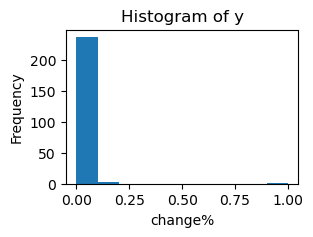

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(3, 2))
plt.hist(y_normalized['lead_value_39051'])
plt.xlabel('change%')
plt.ylabel('Frequency')
plt.title('Histogram of y')

y_train

In [11]:
import pandas as pd

def rw(y):
    # Random walk forecast
    y_rw = y.shift(1).fillna(method='bfill')
    
    return y_rw

yf_rw=rw(y_test)
yv_rw=rw(y_val)

#print(y_test[-3:])
#print(rw(y_test)[-2:])

mse_val_rw = mse(y_val, yv_rw)
mae_val_rw = mae(y_val, yv_rw)
mape_val_rw = mape(y_val, yv_rw)
rmse_val_rw = rmse(y_val, yv_rw)

mse_test_rw = mse(y_test, yf_rw)
mae_test_rw = mae(y_test, yf_rw)
mape_test_rw = mape(y_test, yf_rw)
rmse_test_rw = rmse(y_test, yf_rw)
print(f"Random Walk Forecast:\nMSE: {mse_test_rw[0]}\nMAE: {mae_test_rw[0]}\nMAPE: {mape_test_rw[0]}\nRMSE: {rmse_test_rw[0]}\n")

print("\033[91mRandom Walk Forecast RMSE test:\n\033[0m" + str(rmse_test_rw))
print("\033[91mRandom Walk Forecast RMSE validation:\n\033[0m" + str(rmse_val_rw))

Random Walk Forecast:
MSE: 3.218682444856316
MAE: 0.4284272807580294
MAPE: inf
RMSE: 1.7940686845425724

Random Walk Forecast RMSE test:
lead_value_39051    1.794069
lead_value_39052    1.556114
lead_value_39053    1.027035
lead_value_39054    0.873672
lead_value_39055    0.627272
lead_value_39056    0.285345
lead_value_39063    0.777029
lead_value_39064    2.017834
lead_value_39065    2.003226
lead_value_39066    2.272945
lead_value_39067    2.080034
dtype: float64
Random Walk Forecast RMSE validation:
lead_value_39051    0.176516
lead_value_39052    0.179680
lead_value_39053    0.173248
lead_value_39054    0.178644
lead_value_39055    0.173225
lead_value_39056    0.117138
lead_value_39063    0.286420
lead_value_39064    0.297420
lead_value_39065    0.278198
lead_value_39066    0.217200
lead_value_39067    0.240097
dtype: float64


In [12]:
import statsmodels.api as sm

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

def run_ols(train_x, train_y, test_x):
    # Create an empty DataFrame to store the predictions
    predictions_df = pd.DataFrame(index=test_x.index)
    
    # Iterate over each column of the dependent variable
    for col in train_y.columns:
        # Extract the current column of the dependent variable
        train_y_col = train_y[col]
        #print(col,"\n")
        # Add a constant column to the train_x data
        train_x_const = sm.add_constant(train_x)
        # Fit the OLS model
        #print(train_x_const.index,train_y_col.index)
        model = sm.OLS(train_y_col, train_x_const)
        results = model.fit()
        
        # Add a constant column to the test_x data
        test_x_const = sm.add_constant(test_x,has_constant='add')
        
        # Make predictions using the test_x data
        predictions = results.predict(test_x_const)
        
        # Store the predictions in the DataFrame
        predictions_df[col] = predictions
    
    return predictions_df

# Run the OLS model

ols_train_size=int(len(raw_x) * 0.8)

fv_ols = run_ols(Xnormalizer.normalize_dataframe(raw_x[:ols_train_size-1]), 
Ynormalizer.normalize_dataframe(raw_y[:ols_train_size-1]), 
Xnormalizer.normalize_dataframe(raw_x[ols_train_size-1:]))

rmse_ols = rmse(y_test, Ynormalizer.denormalize_dataframe(fv_ols))

print(f"OLS RMSE: {rmse_ols.sum()}")

OLS RMSE: 17.58040498358444


In [50]:
y_test['lead_value_39051']

2020-07    0.074074
2020-08   -0.103448
2020-09   -0.115385
2020-10    0.173913
2020-11   -0.074074
2020-12    0.000000
2021-01    0.000000
2021-02    0.000000
2021-03    0.000000
2021-04    0.000000
2021-05    0.000000
2021-06    0.000000
2021-07    0.000000
2021-08    0.000000
2021-09    0.000000
2021-10    0.000000
2021-11    0.000000
2021-12    0.000000
2022-01    0.000000
2022-02    0.000000
2022-03    8.880000
2022-04    0.032389
2022-05    0.243137
2022-06   -0.018927
2022-07    0.138264
2022-08    0.081921
2022-09    0.010444
2022-10    0.002584
2022-11   -0.043814
2022-12   -0.024259
2023-01    0.160221
2023-02   -0.121429
2023-03   -0.032520
2023-04    0.204482
2023-05    0.067442
2023-06    0.008715
2023-07    0.032397
2023-08    0.031381
2023-09   -0.058824
2023-10   -0.051724
2023-11   -0.093182
2023-12   -0.027569
2024-01    0.072165
2024-02    0.000000
2024-03    0.000000
2024-04    0.028846
2024-05   -0.072430
2024-06   -0.093199
2024-07    0.000000
Name: lead_value_390

In [13]:
import pandas as pd
import statsmodels.api as sm
import warnings

def fit_arima_model(y, train_percentage, val_percentage, test_percentage, order):
    # Calculate the sizes of each set
    if not isinstance(y.index, pd.DatetimeIndex):
        y.index = pd.to_datetime(y.index)

    if y.index.freq is None:
        y = y.asfreq('MS')  # Replace 'MS' with the correct frequency for your data

    total_samples = len(y)
    train_size = int(total_samples * train_percentage)
    val_size = int(total_samples * val_percentage)
    test_size = total_samples - train_size - val_size

    # Split the data into training, validation, and test sets
    train_y = y[:train_size]
    val_y = y[train_size:train_size+val_size]
    test_y = y[train_size+val_size:]

    # Create empty DataFrames to store the fitted values for validation and test sets
    val_fitted_values_df = pd.DataFrame(index=val_y.index)
    test_fitted_values_df = pd.DataFrame(index=test_y.index)

    # Iterate over each column of the dependent variable
    for col in train_y.columns:
        # Extract the current column of the dependent variable
        train_y_col = train_y[col]

        # Fit the ARIMA model on the train set
        model = sm.tsa.ARIMA(train_y_col, order=order)
        model_fit = model.fit()

        # Get the fitted values for the validation set
        val_fitted_values = model_fit.predict(start=len(train_y_col), end=len(train_y_col) + len(val_y) - 1)

        # Get the fitted values for the test set
        test_fitted_values = model_fit.predict(start=len(train_y_col) + len(val_y), end=len(train_y_col) + len(val_y) + len(test_y) - 1)

        # Store the fitted values in the respective DataFrames
        val_fitted_values_df[col] = val_fitted_values
        test_fitted_values_df[col] = test_fitted_values
    
    val_fitted_values_df.index = val_fitted_values_df.index.to_period('M')
    test_fitted_values_df.index = test_fitted_values_df.index.to_period('M')

    return val_fitted_values_df, test_fitted_values_df



# Define the ARIMA order
order = (1, 0, 0)

# Split y into train, validation, and test sets
train_percentage = 0.72
val_percentage = 0.08
test_percentage = 0.2


val_fitted_values, test_fitted_values = fit_arima_model(raw_y, train_percentage, val_percentage, test_percentage, order)
#print(test_fitted_values)

fv_arima=test_fitted_values 

mse_arima = mse(y_test, fv_arima)
mae_arima = mae(y_test, fv_arima)
mape_arima = mape(y_test, fv_arima)
rmse_arima = rmse(y_test, fv_arima)
print(f"ARIMA Forecast:\nMSE: {mse_arima}\nMAE: {mae_arima}\nMAPE: {mape_arima}\nRMSE: {rmse_arima}")



ARIMA Forecast:
MSE: lead_value_39051   NaN
lead_value_39052   NaN
lead_value_39053   NaN
lead_value_39054   NaN
lead_value_39055   NaN
lead_value_39056   NaN
lead_value_39063   NaN
lead_value_39064   NaN
lead_value_39065   NaN
lead_value_39066   NaN
lead_value_39067   NaN
dtype: float64
MAE: lead_value_39051   NaN
lead_value_39052   NaN
lead_value_39053   NaN
lead_value_39054   NaN
lead_value_39055   NaN
lead_value_39056   NaN
lead_value_39063   NaN
lead_value_39064   NaN
lead_value_39065   NaN
lead_value_39066   NaN
lead_value_39067   NaN
dtype: float64
MAPE: lead_value_39051   NaN
lead_value_39052   NaN
lead_value_39053   NaN
lead_value_39054   NaN
lead_value_39055   NaN
lead_value_39056   NaN
lead_value_39063   NaN
lead_value_39064   NaN
lead_value_39065   NaN
lead_value_39066   NaN
lead_value_39067   NaN
dtype: float64
RMSE: lead_value_39051   NaN
lead_value_39052   NaN
lead_value_39053   NaN
lead_value_39054   NaN
lead_value_39055   NaN
lead_value_39056   NaN
lead_value_39063   N

In [14]:
import pandas as pd
from sklearn.linear_model import Lasso
import joblib

def lasso_regression(x_train, y_train, alpha):
    models = {}  # Dictionary to store models for each dependent variable
    fitted_values = {}  # Dictionary to store fitted values for each dependent variable

    for col in y_train.columns:
        model = Lasso(alpha=alpha)
        model.fit(x_train, y_train[col])
        models[col] = model
        fitted_values[col] = model.predict(x_train)

    return models, fitted_values

def save_models(models, filenames):
    for col, model in models.items():
        joblib.dump(model, filenames[col])

def load_and_predict(filenames, x_test):
    predicted_values = {}
    for col, filename in filenames.items():
        loaded_model = joblib.load(filename)
        predicted_values[col] = loaded_model.predict(x_test)
    return pd.DataFrame(predicted_values,index=x_test.index)


# Example usage:
'''
alpha=0.01
models,fv_train_lasso=lasso_regression(Xnormalizer.normalize_dataframe(x_train),
                                       Ynormalizer.normalize_dataframe(y_train), alpha)
filenames = {col: f'lasso_model_{col}.joblib' for col in models.keys()}
save_models(models, filenames)
fv_lasso=Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))
fv_lasso[:5]
'''

"\nalpha=0.01\nmodels,fv_train_lasso=lasso_regression(Xnormalizer.normalize_dataframe(x_train),\n                                       Ynormalizer.normalize_dataframe(y_train), alpha)\nfilenames = {col: f'lasso_model_{col}.joblib' for col in models.keys()}\nsave_models(models, filenames)\nfv_lasso=Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))\nfv_lasso[:5]\n"

In [15]:
import pandas as pd
from sklearn.linear_model import Ridge
import joblib

def ridge_regression(x_train, y_train, alpha):
    models = {}  # Dictionary to store models for each dependent variable
    fitted_values = {}  # Dictionary to store fitted values for each dependent variable

    for col in y_train.columns:
        model = Ridge(alpha=alpha)
        model.fit(x_train, y_train[col])
        models[col] = model
        fitted_values[col] = model.predict(x_train)

    return models, fitted_values

'''
def save_models(models, filenames):
    for col, model in models.items():
        joblib.dump(model, filenames[col])

def load_and_predict(filenames, x_test):
    predicted_values = {}
    for col, filename in filenames.items():
        loaded_model = joblib.load(filename)
        predicted_values[col] = loaded_model.predict(x_test)
    return pd.DataFrame(predicted_values,index=x_test.index) '''

# Example usage:
'''
alpha=0.1
filenames = {col: f'ridge_model_{col}.joblib' for col in models.keys()}
models,fv_train_ridge=ridge_regression(Xnormalizer.normalize_dataframe(x_train),
                                       Ynormalizer.normalize_dataframe(y_train), alpha)
save_models(models, filenames)
fv_ridge=Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))
fv_ridge['lead_value_39051'][:5],fv_lasso['lead_value_39051'][:15]
'''

"\nalpha=0.1\nfilenames = {col: f'ridge_model_{col}.joblib' for col in models.keys()}\nmodels,fv_train_ridge=ridge_regression(Xnormalizer.normalize_dataframe(x_train),\n                                       Ynormalizer.normalize_dataframe(y_train), alpha)\nsave_models(models, filenames)\nfv_ridge=Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))\nfv_ridge['lead_value_39051'][:5],fv_lasso['lead_value_39051'][:15]\n"

In [16]:
from sklearn.linear_model import SGDRegressor

def sgd_regression(x_train, y_train, penalty='l1',alpha=0.1):
    models = {}  # Dictionary to store models for each dependent variable
    fitted_values = {}  # Dictionary to store fitted values for each dependent variable

    for col in y_train.columns:
        model = SGDRegressor(penalty=penalty, alpha=alpha)
        model.fit(x_train, y_train[col])
        models[col] = model
        fitted_values[col] = model.predict(x_train)

    return models, fitted_values


# Example usage:
'''
alpha=0.1
models,fv_train_sgd=sgd_regression(Xnormalizer.normalize_dataframe(x_train),
                                       Ynormalizer.normalize_dataframe(y_train), alpha)
filenames = {col: f'sgd_model_{col}.joblib' for col in models.keys()}
save_models(models, filenames)
fv_sgd=Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))
rmse(fv_sgd['lead_value_39051'],y_val['lead_value_39051'])
'''


"\nalpha=0.1\nmodels,fv_train_sgd=sgd_regression(Xnormalizer.normalize_dataframe(x_train),\n                                       Ynormalizer.normalize_dataframe(y_train), alpha)\nfilenames = {col: f'sgd_model_{col}.joblib' for col in models.keys()}\nsave_models(models, filenames)\nfv_sgd=Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))\nrmse(fv_sgd['lead_value_39051'],y_val['lead_value_39051'])\n"

In [17]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
import joblib

def random_forest_regression(x_train, y_train, n_estimators, max_depth):
    models = {}  # Dictionary to store models for each dependent variable
    fitted_values = {}  # Dictionary to store fitted values for each dependent variable

    for col in y_train.columns:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=42)
        model.fit(x_train, y_train[col])
        models[col] = model
        fitted_values[col] = model.predict(x_train)

    return models, fitted_values

# Example usage:
'''
n_estimators = 100
max_depth = 10
models, fv_train_random_forest = random_forest_regression(x_train, y_train, n_estimators, max_depth)
filenames = {col: f'random_forest_model_{col}.joblib' for col in models.keys()}
save_models(models, filenames)
fv_rf=load_and_predict(filenames, x_test)
'''

"\nn_estimators = 100\nmax_depth = 10\nmodels, fv_train_random_forest = random_forest_regression(x_train, y_train, n_estimators, max_depth)\nfilenames = {col: f'random_forest_model_{col}.joblib' for col in models.keys()}\nsave_models(models, filenames)\nfv_rf=load_and_predict(filenames, x_test)\n"

In [18]:
import pandas as pd
import xgboost as xgb

def xgboost_regression(x_train, y_train, n_estimators, max_depth):
    models = {}  # Dictionary to store models for each dependent variable
    fitted_values = {}  # Dictionary to store fitted values for each dependent variable

    for col in y_train.columns:
        model = xgb.XGBRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=42)
        model.fit(x_train, y_train[col])
        models[col] = model
        fitted_values[col] = model.predict(x_train)

    return models, fitted_values

In [19]:
from sklearn.ensemble import ExtraTreesRegressor

def extra_tree_regression(x_train, y_train, n_estimators, max_depth, return_feature_importance=False):
    models = {}  
    fitted_values = {}  

    for col in y_train.columns:
        model = ExtraTreesRegressor(n_estimators=n_estimators, max_depth=max_depth,random_state=42)
        model.fit(x_train, y_train[col])
        models[col] = model
        fitted_values[col] = model.predict(x_train)
    
    if return_feature_importance:
        feature_importance = {col: model.feature_importances_ for col, model in models.items()}
        return models, fitted_values, feature_importance
    
    return models, fitted_values

In [20]:
from sklearn.cross_decomposition import PLSRegression

def PLS_save_models(models, filenames):
    for col, model in models.items():
        joblib.dump(model, filenames[col])

def PLS_load_and_predict(filenames, x_test):
    predicted_values = {}
    for col, filename in filenames.items():
        loaded_model = joblib.load(filename)
        items= loaded_model.predict(x_test)
        predicted_values[col] = [item[0] for item in items]
    #print(f"predicted values shape {predicted_values}")
    return pd.DataFrame(predicted_values,index=x_test.index)

def pls_regression(x_train, y_train, n_components):
    models = {}  # Dictionary to store models for each dependent variable
    fitted_values = {}  # Dictionary to store fitted values for each dependent variable

    for col in y_train.columns:
        model = PLSRegression(n_components=n_components)
        model.fit(x_train, y_train[col])
        models[col] = model
        temp = model.predict(x_train)
        fitted_values[col] = [item[0] for item in temp]  # Remove brackets from items in temp
        
    return models, fitted_values

# Example usage:
'''
n_components = 2
models, fv_train_pls = pls_regression(x_train, y_train, n_components)
filenames = {col: f'pls_model_{col}.joblib' for col in models.keys()}
save_models(models, filenames)
fv_pls = PLS_load_and_predict(filenames, x_test)
'''

"\nn_components = 2\nmodels, fv_train_pls = pls_regression(x_train, y_train, n_components)\nfilenames = {col: f'pls_model_{col}.joblib' for col in models.keys()}\nsave_models(models, filenames)\nfv_pls = PLS_load_and_predict(filenames, x_test)\n"

In [21]:
'''
from sklearn.svm import SVR
def svm_regression(x_train, y_train, kernel='rbf', C=1.0, epsilon=0.1):
    models = {}  # Dictionary to store models for each dependent variable
    fitted_values = {}  # Dictionary to store fitted values for each dependent variable

    for col in y_train.columns:
        model = SVR(kernel=kernel, C=C, epsilon=epsilon)
        model.fit(x_train, y_train[col])
        models[col] = model
        fitted_values[col] = model.predict(x_train)

    return models, fitted_values

# Example usage:
models, fv_train_svm = svm_regression(x_train, y_train, kernel='linear', C=0.5, epsilon=0.01)
filenames = {col: f'svm_model_{col}.joblib' for col in models.keys()}
save_models(models, filenames)
fv_svm = load_and_predict(filenames, x_test)'''

"\nfrom sklearn.svm import SVR\ndef svm_regression(x_train, y_train, kernel='rbf', C=1.0, epsilon=0.1):\n    models = {}  # Dictionary to store models for each dependent variable\n    fitted_values = {}  # Dictionary to store fitted values for each dependent variable\n\n    for col in y_train.columns:\n        model = SVR(kernel=kernel, C=C, epsilon=epsilon)\n        model.fit(x_train, y_train[col])\n        models[col] = model\n        fitted_values[col] = model.predict(x_train)\n\n    return models, fitted_values\n\n# Example usage:\nmodels, fv_train_svm = svm_regression(x_train, y_train, kernel='linear', C=0.5, epsilon=0.01)\nfilenames = {col: f'svm_model_{col}.joblib' for col in models.keys()}\nsave_models(models, filenames)\nfv_svm = load_and_predict(filenames, x_test)"

In [22]:
import os
os.getcwd()

'c:\\Users\\Alireza\\OneDrive\\Backup\\Yield Curve Pricing\\data'

In [23]:
# Running the NN model
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.metrics import mean_squared_error

def train_neural_network(X_train, y_train, save_filenames, layer1=64, layer2=32, epochs=10):
    models = {}  # Dictionary to store models for each dependent variable

    # Iterate over each column of the dependent variable
    for col in y_train.columns:
        # Create a new model
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(layer1, activation='relu'))
        model.add(Dense(layer2, activation='relu'))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Fit the model on the training data
        model.fit(X_train, y_train[col], epochs=epochs, batch_size=32, verbose=0)

        # Save the model for future use
        models[col] = model
        model.save(f'nueral network/{save_filenames[col]}')

    return models

# Compute the MSE for x_val

def load_and_predict_nn(filenames, x_test):
    predicted_values = {}
    for col, filename in filenames.items():
        model = tf.keras.models.load_model(f'nueral network/{filename}')
        predicted_values[col] = model.predict(x_test).flatten()
    return pd.DataFrame(predicted_values, index=x_test.index)


# Load the saved models
"""
saved_filenames = {col: f'model_{col}.keras' for col in y_train.columns}
models=train_neural_network(x_train, y_train, saved_filenames)
predicted_values_nn = load_and_predict_nn(saved_filenames, x_test)
"""

"\nsaved_filenames = {col: f'model_{col}.keras' for col in y_train.columns}\nmodels=train_neural_network(x_train, y_train, saved_filenames)\npredicted_values_nn = load_and_predict_nn(saved_filenames, x_test)\n"

In [24]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Reshape, LSTM
import pandas as pd


def train_neural_LSTM(X_train, y_train, save_filenames, layer1=64, layer2=32, lstm_units=32, epochs=10):
    models = {}  # Dictionary to store models for each dependent variable

    # Iterate over each column of the dependent variable
    for col in y_train.columns:
        # Create a new model
        model = Sequential()
        model.add(Input(shape=(X_train.shape[1],)))
        model.add(Dense(layer1, activation='relu'))
        model.add(Dense(layer2, activation='relu'))
        model.add(tf.keras.layers.Reshape((layer2, 1)))
        model.add(LSTM(lstm_units))
        model.add(Dense(1, activation='linear'))
        model.compile(loss='mean_squared_error', optimizer='adam')

        # Fit the model on the training data
        model.fit(X_train, y_train[col], epochs=epochs, batch_size=32, verbose=0)

        # Save the model for future use
        models[col] = model
        model.save(f'nueral network/{save_filenames[col]}')

    return models

def load_and_predict_nn_LSTM(filenames, x_test):
    predicted_values = {}
    for col, filename in filenames.items():
        model = tf.keras.models.load_model(f'nueral network/{filename}')
        predicted_values[col] = model.predict(x_test).flatten()
    return pd.DataFrame(predicted_values, index=x_test.index)

# Load the saved models
'''
saved_filenames = {col: f'model_lstm_{col}.keras' for col in y_train.columns}
models=train_neural_LSTM(x_train, y_train, saved_filenames)
predicted_values_nn = load_and_predict_nn_LSTM(saved_filenames, x_test)
'''


"\nsaved_filenames = {col: f'model_lstm_{col}.keras' for col in y_train.columns}\nmodels=train_neural_LSTM(x_train, y_train, saved_filenames)\npredicted_values_nn = load_and_predict_nn_LSTM(saved_filenames, x_test)\n"

In [25]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
import warnings

warnings.filterwarnings("ignore", 'Do not pass an `input_shape`', module='tensorflow')

def nn_pls_model(raw_x,raw_y,n_components=5,epochs=15,layer1=64,layer2=32):
    predicted_values_test={}
    predicted_values_val={}
    for i in range(len(raw_y.columns)):

        # Create the PLS regression model
        pls_model = PLSRegression(n_components=n_components)

        # Fit the model to the data
        pls_model.fit(x_normalized, y_normalized.iloc[:, i])

        # Get the top 20 variable outcomes
        top_20_outcomes = pls_model.x_scores_
        x_shrunk= pls_model.transform(x_normalized)
        x_shrunk = pd.DataFrame(pls_model.transform(x_normalized.iloc[:int(0.72*len(x_normalized)),]) )
        # Apply PLS shrinkage on x_test
        x_test_shrunk = pd.DataFrame(pls_model.transform(x_normalized.iloc[int(0.8*len(x_normalized)):,]))

        train_percentage = 0.72
        val_percentage = 0.08
        test_percentage = 0.2

        # Calculate the sizes of each set
        total_samples = len(x_normalized)
        train_size = int(total_samples * train_percentage)
        val_size = int(total_samples * val_percentage)
        test_size = total_samples - train_size - val_size

        # Split the data into training, validation, and test sets
        x_train = top_20_outcomes[:train_size]
        x_val = top_20_outcomes[train_size:train_size+val_size]
        x_test = top_20_outcomes[train_size+val_size:]

        y_train = raw_y[:train_size]
        y_val = raw_y[train_size:train_size+val_size]
        y_test = raw_y[train_size+val_size:]

        x_train=pd.DataFrame(x_train)
        y_train=pd.DataFrame(y_train)   
        x_test=pd.DataFrame(x_test)
        y_test=pd.DataFrame(y_test)

        # Add layers to the model
        model = Sequential()
        model.add(Input(shape=(x_train.shape[1],)))
        model.add(Dense(layer1, activation='relu'))
        model.add(Dense(layer2, activation='relu'))
        model.add(Dense(1))

        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        # Fit the model to the training data
        model.fit(x_train, y_train, epochs=epochs, batch_size=8,verbose=0)

        # Make predictions on the test data
        y_val_pred = model.predict(x_val)
        y_test_pred=model.predict(x_test)
        predicted_values_val[raw_y.columns[i]] = y_val_pred.flatten()
        predicted_values_test[raw_y.columns[i]] = y_test_pred.flatten()
    return(pd.DataFrame(predicted_values_val,index=y_val.index),
           pd.DataFrame(predicted_values_test,index=y_test.index))

In [26]:
nn_pls_val,nn_pls_test=nn_pls_model(raw_x,raw_y,n_components=2,epochs=1,layer1=4,layer2=4)

2/2 [==============================] - 0s 5ms/step


This part onward fine tunes

In [27]:
"""
The models are:
1- OLS
2- ARIMA
3- LASSO
4- Ridge
5- SGD
6- Random Forest
7- XGboost
8- Extreme Trees
9-PLS
10- Nueral Networks
11-LSTM
12- PLS+NN
"""

'\nThe models are:\n1- OLS\n2- ARIMA\n3- LASSO\n4- Ridge\n5- SGD\n6- Random Forest\n7- XGboost\n8- Extreme Trees\n9-PLS\n10- Nueral Networks\n11-LSTM\n12- PLS+NN\n'

In [28]:
# Random walk Error
print(f"Random Walk Error: {sum(rmse_test_rw)}")
# OLS Error
print(f"OLS Error: {sum(rmse_ols)}")

Random Walk Error: 15.314575727287238
OLS Error: 17.580404983584437


In [29]:
import warnings

warnings.warn("This is a warning message", UserWarning)

arima_settings = [(1, 0, 0), (0, 1, 0), (0, 0, 1), (1, 1, 0), (0, 1, 1), (2, 0, 0), (0, 2, 0), (0, 0, 2), (2, 1, 0), (0, 2, 1)]  # Updated ARIMA settings

rmse_val_arima = {}
for arima_setting in arima_settings:
    order = arima_setting
    val_fitted_values, test_fitted_values = fit_arima_model(raw_y, train_percentage, val_percentage, test_percentage, order)
    rmse_arima = rmse(y_val, val_fitted_values)
    errors = sum(rmse_arima)
    print(f"ARIMA Forecast for {arima_setting}: RMSE: {errors}")
    rmse_val_arima[f"ARIMA Forecast for {arima_setting}"] = errors

C:\Users\Alireza\AppData\Local\Temp\ipykernel_936\2827984830.py:3: UserWarning: This is a warning message
  warnings.warn("This is a warning message", UserWarning)


ARIMA Forecast for (1, 0, 0): RMSE: nan
ARIMA Forecast for (0, 1, 0): RMSE: nan
ARIMA Forecast for (0, 0, 1): RMSE: nan
ARIMA Forecast for (1, 1, 0): RMSE: nan


e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ARIMA Forecast for (0, 1, 1): RMSE: nan
ARIMA Forecast for (2, 0, 0): RMSE: nan
ARIMA Forecast for (0, 2, 0): RMSE: nan
ARIMA Forecast for (0, 0, 2): RMSE: nan
ARIMA Forecast for (2, 1, 0): RMSE: nan


e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels

ARIMA Forecast for (0, 2, 1): RMSE: nan


e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [30]:
alpha_values = [0.001,0.01, 0.1, 1.0]  # List of alpha values to iterate over
rmse_val_lasso = {}

for alpha in alpha_values:
    models, fv_train_lasso = lasso_regression(Xnormalizer.normalize_dataframe(x_train),
                                              Ynormalizer.normalize_dataframe(y_train), alpha)
    filenames = {col: f'lasso_model_{col}.joblib' for col in models.keys()}
    save_models(models, filenames)
    fv_lasso = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))
    l = rmse(y_val, fv_lasso)
    errors = sum(l)
    print(f"Alpha: {alpha}, Error: {errors}")
    rmse_val_lasso[f"Alpha: {alpha}"] = errors

Alpha: 0.001, Error: 2.589983331988494
Alpha: 0.01, Error: 2.037502052703111
Alpha: 0.1, Error: 2.0374646555559357
Alpha: 1.0, Error: 2.0374646555559357


In [31]:
alpha_values = [0.001, 0.01, 0.1, 1.0]  # List of alpha values to iterate over

rmse_val_ridge = {}

for alpha in alpha_values:
    models, fv_train_ridge = ridge_regression(Xnormalizer.normalize_dataframe(x_train),
                                              Ynormalizer.normalize_dataframe(y_train), alpha)
    filenames = {col: f'ridge_model_{col}.joblib' for col in models.keys()}
    save_models(models, filenames)
    fv_ridge = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))
    l = rmse(y_val, fv_ridge)
    errors = sum(l)
    print(f"Alpha: {alpha}, Error: {errors}")
    rmse_val_ridge[f"Alpha: {alpha}"] = errors

Alpha: 0.001, Error: 23.05976716607876
Alpha: 0.01, Error: 17.879041617087108
Alpha: 0.1, Error: 9.048239507224665
Alpha: 1.0, Error: 3.338672615059912


In [32]:
penalties = ['l1', 'l2','elasticnet']  # List of penalty values to iterate over
alphas = [0.001, 0.01, 0.1, 1.0]  # List of alpha values to iterate over
rmse_val_sgd = {}
for penalty in penalties:
    for alpha in alphas:
        models, fv_train_sgd = sgd_regression(Xnormalizer.normalize_dataframe(x_train),
                                              Ynormalizer.normalize_dataframe(y_train), penalty=penalty, alpha=alpha)
        filenames = {col: f'sgd_model_{col}.joblib' for col in models.keys()}
        save_models(models, filenames)
        fv_sgd = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))
        l = rmse(fv_sgd, y_val)
        error = sum(l)
        print(f"Penalty: {penalty}, Alpha: {alpha}, Error: {error}")
        rmse_val_sgd[f"Penalty: {penalty}, Alpha: {alpha}"] = error

Penalty: l1, Alpha: 0.001, Error: 2.0746770550221525
Penalty: l1, Alpha: 0.01, Error: 2.128132084804599
Penalty: l1, Alpha: 0.1, Error: 1.9574430484500356
Penalty: l1, Alpha: 1.0, Error: 1.9940130369567597
Penalty: l2, Alpha: 0.001, Error: 2.2043706353908856
Penalty: l2, Alpha: 0.01, Error: 2.1564112797515356
Penalty: l2, Alpha: 0.1, Error: 2.247671698065401
Penalty: l2, Alpha: 1.0, Error: 2.185811975297578
Penalty: elasticnet, Alpha: 0.001, Error: 2.129909089421397
Penalty: elasticnet, Alpha: 0.01, Error: 2.043246314721519
Penalty: elasticnet, Alpha: 0.1, Error: 2.398198287859678
Penalty: elasticnet, Alpha: 1.0, Error: 1.9875520490825713


In [33]:
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
rmse_val_rf = {}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        models, fv_train_random_forest = random_forest_regression(Xnormalizer.normalize_dataframe(x_train), 
                                                                  Ynormalizer.normalize_dataframe(y_train)
                                                                  , n_estimators, max_depth)
        filenames = {col: f'random_forest_model_{col}.joblib' for col in models.keys()}
        save_models(models, filenames)
        fv_rf = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))
        l = rmse(fv_rf,y_val)
        errors = sum(l)
        print(f"Random Forest (n_estimators={n_estimators}, max_depth={max_depth}): {errors}")
        rmse_val_rf[f"Random Forest (n_estimators={n_estimators}, max_depth={max_depth})"] = errors


Random Forest (n_estimators=50, max_depth=5): 2.277534933868784
Random Forest (n_estimators=50, max_depth=10): 2.3029129058014357
Random Forest (n_estimators=50, max_depth=15): 2.271085751629758
Random Forest (n_estimators=100, max_depth=5): 2.2906820303536093
Random Forest (n_estimators=100, max_depth=10): 2.3009040501067832
Random Forest (n_estimators=100, max_depth=15): 2.2886276470843643
Random Forest (n_estimators=150, max_depth=5): 2.288167971727024
Random Forest (n_estimators=150, max_depth=10): 2.2998969474485342
Random Forest (n_estimators=150, max_depth=15): 2.2891010141240935


In [34]:
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
rmse_val_xgboost = {}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        models, fv_train_xgboost = xgboost_regression(Xnormalizer.normalize_dataframe(x_train), 
                                                      Ynormalizer.normalize_dataframe(y_train),
                                                      n_estimators, max_depth)
        filenames = {col: f'xgboost_model_{col}.joblib' for col in models.keys()}
        save_models(models, filenames)
        fv_xgboost = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))
        l = rmse(fv_xgboost, y_val)
        errors = sum(l)
        print(f"XGBoost (n_estimators={n_estimators}, max_depth={max_depth}): {errors}")
        rmse_val_xgboost[f"XGBoost (n_estimators={n_estimators}, max_depth={max_depth})"] = errors

XGBoost (n_estimators=50, max_depth=5): 2.2382036886596803
XGBoost (n_estimators=50, max_depth=10): 2.4296844199774448
XGBoost (n_estimators=50, max_depth=15): 2.4631091100936526
XGBoost (n_estimators=100, max_depth=5): 2.238140190550444
XGBoost (n_estimators=100, max_depth=10): 2.429684581840332
XGBoost (n_estimators=100, max_depth=15): 2.463109209357113
XGBoost (n_estimators=150, max_depth=5): 2.2381401952653035
XGBoost (n_estimators=150, max_depth=10): 2.429684612408563
XGBoost (n_estimators=150, max_depth=15): 2.4631091929351703


In [35]:
n_estimators_values = [50, 100, 150]
max_depth_values = [5, 10, 15]
rmse_val_extreme = {}
feature_total={}

for n_estimators in n_estimators_values:
    for max_depth in max_depth_values:
        models, fv_train_xtreme, features = extra_tree_regression(Xnormalizer.normalize_dataframe(x_train), 
                                                            Ynormalizer.normalize_dataframe(y_train),
                                                            n_estimators, max_depth, return_feature_importance=True)
        filenames = {col: f'Xtreme_tree_model_{col}.joblib' for col in models.keys()}
        save_models(models, filenames)
        fv_extreme = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_val)))
        l = rmse(fv_extreme, y_val)
        errors = sum(l)
        print(f"extreme tree (n_estimators={n_estimators}, max_depth={max_depth}): {errors}")
        rmse_val_extreme[f"extreme tree (n_estimators={n_estimators}, max_depth={max_depth})"] = errors
        feature_total[f"(n_estimators={n_estimators}, max_depth={max_depth})"]=features

extreme tree (n_estimators=50, max_depth=5): 2.2491290720350046
extreme tree (n_estimators=50, max_depth=10): 2.1987711296706594
extreme tree (n_estimators=50, max_depth=15): 2.249627069396408
extreme tree (n_estimators=100, max_depth=5): 2.220702148710955
extreme tree (n_estimators=100, max_depth=10): 2.1976942450302843
extreme tree (n_estimators=100, max_depth=15): 2.21550871609382
extreme tree (n_estimators=150, max_depth=5): 2.2120394032841486
extreme tree (n_estimators=150, max_depth=10): 2.20275639486117
extreme tree (n_estimators=150, max_depth=15): 2.2191943253198714


In [36]:

n_components_values = [2, 5, 10, 20]
rmse_val_pls = {}

for n_components in n_components_values:
    models, fv_train_pls = pls_regression(x_train, y_train, n_components)
    filenames = {col: f'pls_model_{col}.joblib' for col in models.keys()}
    save_models(models, filenames)
    fv_pls = PLS_load_and_predict(filenames, x_val)
    l=rmse(fv_pls, y_val)
    errors = sum(l)
    print(f"PLS (n_components={n_components}): {errors}")  
    rmse_val_pls[f"PLS (n_components={n_components})"] = errors

PLS (n_components=2): 2.289964814291149
PLS (n_components=5): 2.606140162571514
PLS (n_components=10): 2.9000530053921487
PLS (n_components=20): 3.473761572213263


In [37]:
rmse_val_nn = {}
for layer1 in [64, 128]:
    for layer2 in [32, 64]:
        saved_filenames = {col: f'model_{col}.keras' for col in y_train.columns}
        models = train_neural_network(Xnormalizer.normalize_dataframe(x_train), 
                                      Ynormalizer.normalize_dataframe(y_train), saved_filenames,layer1,layer2,epochs=10)
        predicted_values_nn = Ynormalizer.denormalize_dataframe(load_and_predict_nn(saved_filenames, Xnormalizer.normalize_dataframe(x_val)))
        l = rmse(predicted_values_nn, y_val)
        errors = sum(l)
        print(f"Neural Network (layer1={layer1}, layer2={layer2}): {errors}")
        rmse_val_nn[f"Neural Network (layer1={layer1}, layer2={layer2})"] = errors

1/1 [==============================] - 0s 64ms/step
Neural Network (layer1=64, layer2=32): 2.641837778314605
1/1 [==============================] - 0s 57ms/step
Neural Network (layer1=64, layer2=64): 2.558155186175078
1/1 [==============================] - 0s 84ms/step
Neural Network (layer1=128, layer2=32): 2.692337470292018
1/1 [==============================] - 0s 59ms/step
Neural Network (layer1=128, layer2=64): 2.6573651175437143


In [38]:
rmse_val_lstm={}
for layer1 in [64, 128]:
    for layer2 in [32, 64]:
        for lstm in [16,32]:
            saved_filenames = {col: f'model_lstm_{col}.keras' for col in y_train.columns}
            models = train_neural_LSTM(Xnormalizer.normalize_dataframe(x_train), 
                                    Ynormalizer.normalize_dataframe(y_train), saved_filenames, layer1, layer2,lstm, epochs=10)
            predicted_values_nn_lstm = Ynormalizer.denormalize_dataframe(load_and_predict_nn(saved_filenames, Xnormalizer.normalize_dataframe(x_val)))
            l = rmse(predicted_values_nn_lstm, y_val)
            errors = sum(l)
            print(f"Neural Network LSTM (layer1={layer1}, layer2={layer2}, lstm={lstm}): {errors}")
            rmse_val_lstm[f"Neural Network LSTM (layer1={layer1}, layer2={layer2}, lstm={lstm})"] = errors


1/1 [==============================] - 0s 469ms/step
Neural Network LSTM (layer1=64, layer2=32, lstm=16): 2.079984467553925
1/1 [==============================] - 0s 466ms/step
Neural Network LSTM (layer1=64, layer2=32, lstm=32): 2.067332325619753
1/1 [==============================] - 0s 468ms/step
Neural Network LSTM (layer1=64, layer2=64, lstm=16): 2.037667557096569
1/1 [==============================] - 0s 464ms/step
Neural Network LSTM (layer1=64, layer2=64, lstm=32): 2.1235582180411257
1/1 [==============================] - 1s 626ms/step
Neural Network LSTM (layer1=128, layer2=32, lstm=16): 1.993286089603307
1/1 [==============================] - 0s 462ms/step
Neural Network LSTM (layer1=128, layer2=32, lstm=32): 1.9945123573861772
1/1 [==============================] - 0s 461ms/step
Neural Network LSTM (layer1=128, layer2=64, lstm=16): 1.9955528191882865
1/1 [==============================] - 0s 465ms/step
Neural Network LSTM (layer1=128, layer2=64, lstm=32): 2.0773721159763157


In [39]:
n_components_values = [2, 5, 10, 20]
layer1_values = [64,128]
layer2_values = [32,64]
rmse_val_pls_nn = {}
nn_pls_test={}
for n_components in n_components_values:
    for layer1 in layer1_values:
        for layer2 in layer2_values:
            nn_pls_pred_val, nn_pls_pred_test = nn_pls_model(Xnormalizer.normalize_dataframe(raw_x),
                                                Ynormalizer.normalize_dataframe(raw_y),
                                                n_components=n_components, 
                                                layer1=layer1, layer2=layer2)
            nn_pls_pred_val=Ynormalizer.denormalize_dataframe(nn_pls_pred_val)
            nn_pls_pred_test=Ynormalizer.denormalize_dataframe(nn_pls_pred_test)
            rmse_pls_nn = rmse(nn_pls_pred_val, y_val)
            test= rmse(nn_pls_pred_test, y_test)
            errors = sum(rmse_pls_nn)
            print(f"PLS+NN (n_components={n_components}, layer1={layer1}, layer2={layer2}): {errors}")
            rmse_val_pls_nn[f"PLS+NN (n_components={n_components}, layer1={layer1}, layer2={layer2})"] = errors
            nn_pls_test[f"PLS+NN (n_components={n_components}, layer1={layer1}, layer2={layer2})"] =test

2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=2, layer1=64, layer2=32): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=2, layer1=64, layer2=64): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=2, layer1=128, layer2=32): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=2, layer1=128, layer2=64): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=5, layer1=64, layer2=32): nan
2/2 [==============================] - 0s 4ms/step
PLS+NN (n_components=5, layer1=64, layer2=64): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=5, layer1=128, layer2=32): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=5, layer1=128, layer2=64): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=10, layer1=64, layer2=32): nan
2/2 [==============================] - 0s 3ms/step
PLS+NN (n_components=10, l

Here, we run all the regressions again but this time on optimized hyperparameters and 
x_test, y_test

In [40]:
"""
The models are:
1- OLS
2- ARIMA
3- LASSO
4- Ridge
5- SGD
6- Random Forest
7- XGboost
8-PLS
9- SVM ?
10- Nueral Networks
11-LSTM
11- PLS+NN
"""

'\nThe models are:\n1- OLS\n2- ARIMA\n3- LASSO\n4- Ridge\n5- SGD\n6- Random Forest\n7- XGboost\n8-PLS\n9- SVM ?\n10- Nueral Networks\n11-LSTM\n11- PLS+NN\n'

In [41]:
import pandas as pd 

validation_rmse_results={}

validation_rmse_results['ols']=('ols',sum(rmse_ols))
validation_rmse_results['ARIMA']=min(rmse_val_arima.items(), key=lambda x: x[1])
validation_rmse_results['lasso']=min(rmse_val_lasso.items(), key=lambda x: x[1])
validation_rmse_results['ridge']=min(rmse_val_ridge.items(), key=lambda x: x[1])
validation_rmse_results['sgd']=min(rmse_val_sgd.items(), key=lambda x: x[1])
validation_rmse_results['rf']=min(rmse_val_rf.items(), key=lambda x: x[1])
validation_rmse_results['xgboost']=min(rmse_val_xgboost.items(), key=lambda x: x[1])
validation_rmse_results['extreme_trees']=min(rmse_val_extreme.items(),key=lambda x: x[1])
validation_rmse_results['pls']=min(rmse_val_pls.items(), key=lambda x: x[1])
validation_rmse_results['nn']=min(rmse_val_nn.items(), key=lambda x: x[1])
validation_rmse_results['lstm']=min(rmse_val_lstm.items(), key=lambda x: x[1])
validation_rmse_results['pls_nn']=min(rmse_val_pls_nn.items(), key=lambda x: x[1])

validation_rmse_results2=pd.DataFrame(validation_rmse_results)
validation_rmse_results2=validation_rmse_results2.transpose()

validation_rmse_results2

,0,1
ols,ols,17.580405
ARIMA,"ARIMA Forecast for (1, 0, 0)",NaN
lasso,Alpha: 0.1,2.037465
ridge,Alpha: 1.0,3.338673
sgd,"Penalty: l1, Alpha: 0.1",1.957443
rf,"Random Forest (n_estimators=50, max_depth=15)",2.271086
xgboost,"XGBoost (n_estimators=100, max_depth=5)",2.23814
extreme_trees,"extreme tree (n_estimators=100, max_depth=10)",2.197694
pls,PLS (n_components=2),2.289965
nn,"Neural Network (layer1=64, layer2=64)",2.558155


In [ ]:
order=(0,0,2)
val_fitted_values, test_fitted_values = fit_arima_model(raw_y, train_percentage, val_percentage, test_percentage, order)
rmse_test_arima = rmse(y_test, test_fitted_values)
mae_test_arima=mae(y_test, test_fitted_values)

e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
e:\Users\Alireza\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will b

In [ ]:
import os
folder_name = "modela"
alpha=0.1

# Create the directory if it does not exist
os.makedirs(folder_name, exist_ok=True)

models, fv_train_lasso = lasso_regression(Xnormalizer.normalize_dataframe(x_train),
                                          Ynormalizer.normalize_dataframe(y_train), alpha)

filenames = {col: os.path.join(folder_name, f'lasso_model_{col}.joblib') for col in models.keys()}
save_models(models, filenames)
# Calculate the RMSE on the test data
ft_lasso = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))
rmse_test_lasso = rmse(y_test,ft_lasso)

In [ ]:
# Create the directory if it does not exist
alpha=1.0

os.makedirs(folder_name, exist_ok=True)

models, fv_train_ridge = ridge_regression(Xnormalizer.normalize_dataframe(x_train),
                                          Ynormalizer.normalize_dataframe(y_train), alpha)

filenames = {col: os.path.join(folder_name, f'ridge_model_{col}.joblib') for col in models.keys()}
save_models(models, filenames)
# Calculate the RMSE on the test data
ft_ridge = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))
rmse_test_ridge = rmse(y_test, ft_ridge)

In [ ]:
alpha=1.0
Penalty='elasticnet'

os.makedirs(folder_name, exist_ok=True)
models, fv_train_sgd = sgd_regression(Xnormalizer.normalize_dataframe(x_train),
                                      Ynormalizer.normalize_dataframe(y_train), penalty='elasticnet', alpha=alpha)

filenames = {col: os.path.join(folder_name, f'sgd_model_{col}.joblib') for col in models.keys()}
save_models(models, filenames)
# Calculate the RMSE on the test data
ft_sgd = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))
rmse_test_sgd = rmse(y_test, ft_sgd)

In [ ]:
n_estimators=50
max_depth=5

os.makedirs(folder_name, exist_ok=True)
models, fv_train_random_forest = random_forest_regression(Xnormalizer.normalize_dataframe(x_train), 
                                                          Ynormalizer.normalize_dataframe(y_train), n_estimators, max_depth)
filenames = {col: os.path.join(folder_name, f'random_forest_model_{col}.joblib') for col in models.keys()}
save_models(models, filenames)
# Calculate the RMSE on the test data
ft_rf = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))
rmse_test_rf = rmse(y_test, ft_rf)
mae_test_rf=mae(y_test, ft_rf)

In [ ]:
# Set the hyperparameters for XGBoost
n_estimators = 150
max_depth = 5

# Train the XGBoost model
models, fv_train_xgboost = xgboost_regression(Xnormalizer.normalize_dataframe(x_train), 
                                              Ynormalizer.normalize_dataframe(y_train),
                                              n_estimators, max_depth)

# Save the trained models
filenames = {col: f'xgboost_model_{col}.joblib' for col in models.keys()}
save_models(models, filenames)

# Calculate the predicted values on the test data
ft_xgboost = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))

# Calculate the RMSE on the test data
rmse_test_xgboost = rmse(y_test, ft_xgboost)

In [ ]:
n_estimators=150
max_depth=5

os.makedirs(folder_name, exist_ok=True)
models, fv_train_extra_trees = extra_tree_regression(Xnormalizer.normalize_dataframe(x_train), 
                                                          Ynormalizer.normalize_dataframe(y_train), n_estimators, max_depth)
filenames = {col: os.path.join(folder_name, f'Xtreme_tree_model_{col}.joblib') for col in models.keys()}
save_models(models, filenames)
# Calculate the RMSE on the test data
ft_xt = Ynormalizer.denormalize_dataframe(load_and_predict(filenames, Xnormalizer.normalize_dataframe(x_test)))
rmse_test_xt = rmse(y_test, ft_xt)
mae_test_xt=mae(y_test, ft_xt)

In [ ]:
# run pls model
n_components=2

os.makedirs(folder_name, exist_ok=True)

models, fv_train_pls = pls_regression(x_train, y_train, n_components)
filenames = {col: os.path.join(folder_name, f'pls_model_{col}.joblib') for col in models.keys()}
save_models(models, filenames)
# Calculate the RMSE on the test data
ft_pls = PLS_load_and_predict(filenames, x_test)
rmse_test_pls= rmse(y_test, ft_pls)

In [ ]:
# neurel network model
layer1=64
layer2=64

# Run the neural network model
saved_filenames = {col: f'model_{col}.keras' for col in y_train.columns}
models = train_neural_network(Xnormalizer.normalize_dataframe(x_train), 
                              Ynormalizer.denormalize_dataframe(y_train), saved_filenames, layer1, layer2)
predicted_values_nn = load_and_predict_nn(saved_filenames, Xnormalizer.normalize_dataframe(x_test))
rmse_test_nn = rmse(y_test, predicted_values_nn)

2/2 [==============================] - 0s 5ms/step


In [ ]:
# LSTM
# neurel network model
layer1=64
layer2=64
lstm=16

# Run the neural network model
saved_filenames = {col: f'model_lstm_{col}.keras' for col in y_train.columns}
models = train_neural_LSTM(Xnormalizer.normalize_dataframe(x_train), 
                              Ynormalizer.denormalize_dataframe(y_train), saved_filenames, layer1, layer2,lstm)
predicted_values_nn_lstm = load_and_predict_nn_LSTM(saved_filenames, Xnormalizer.normalize_dataframe(x_test))
rmse_test_nn_lstm = rmse(y_test, predicted_values_nn_lstm)

2/2 [==============================] - 0s 6ms/step


In [ ]:
# Run the PLS_nn algorithm on the test sample
"""
n_components = 20
layer1 = 128
layer2 = 64

nn_pls_test2=nn_pls_test[f"PLS+NN (n_components={n_components}, layer1={layer1}, layer2={layer2})"]
rmse_test_nn_pls=sum(nn_pls_test2) """

'\nn_components = 20\nlayer1 = 128\nlayer2 = 64\n\nnn_pls_test2=nn_pls_test[f"PLS+NN (n_components={n_components}, layer1={layer1}, layer2={layer2})"]\nrmse_test_nn_pls=sum(nn_pls_test2) '

In [ ]:
# Create the final team
test_rmse_results={}

test_rmse_results['rw']=rmse_test_rw
test_rmse_results['ols']=rmse_ols
test_rmse_results['ARIMA']=rmse_test_arima
test_rmse_results['lasso']=rmse_test_lasso
test_rmse_results['ridge']=rmse_test_ridge
test_rmse_results['sgd']=rmse_test_sgd
test_rmse_results['rf']=rmse_test_rf
test_rmse_results['xgboost']=rmse_test_xgboost
test_rmse_results['extreme_trees']=rmse_test_xt
test_rmse_results['pls']=rmse_test_pls
test_rmse_results['nn']=rmse_test_nn
test_rmse_results['lstm']=rmse_test_nn_lstm
#test_rmse_results['pls_nn']=rmse_test_nn_pls

test_rmse_results=pd.DataFrame(test_rmse_results)


In [ ]:
test_rmse_results_sum=pd.DataFrame(test_rmse_results.sum(axis=0))
val_test_table=pd.merge(validation_rmse_results2,test_rmse_results_sum,left_index=True, right_index=True)

val_test_table['Rank'] = val_test_table["0_y"].rank(ascending=True)
val_test_table[1]=pd.to_numeric(val_test_table[1])
val_test_table.columns=["Best Performing Hyperparameters", "Performance in Validation Dataset (SMRSE)" , "Performance in Test Dataset (SMRSE)" , "Ranking Based on Performance on Test Dataset"]

val_test_table = val_test_table.round(2)
val_test_table.to_csv("results/validation_test.csv")
val_test_table

,Best Performing Hyperparameters,Performance in Validation Dataset (SMRSE),Performance in Test Dataset (SMRSE),Ranking Based on Performance on Test Dataset
ols,ols,13.65,13.65,11.0
ARIMA,"ARIMA Forecast for (2, 1, 0)",1.97,10.86,4.0
lasso,Alpha: 0.1,2.04,10.86,5.0
ridge,Alpha: 1.0,3.07,10.89,7.0
sgd,"Penalty: l1, Alpha: 0.1",1.93,10.88,6.0
rf,"Random Forest (n_estimators=150, max_depth=5)",2.28,10.80,2.0
xgboost,"XGBoost (n_estimators=50, max_depth=5)",2.27,10.84,3.0
extreme_trees,"extreme tree (n_estimators=50, max_depth=5)",2.28,10.73,1.0
pls,PLS (n_components=2),2.22,10.90,8.0
nn,"Neural Network (layer1=128, layer2=64)",2.40,12.89,10.0


In [ ]:
import pandas as pd

data = {'mae_test_xt': mae_test_xt, 'mae_test_rf': mae_test_rf, 'mae_test_arima': mae_test_arima}
df = pd.DataFrame(data)
df.index=[
 "2-year yield",
 "3-year yield",
 "5-year yield",
"7-year yield",
"10-year yield",
"long-term yield",
"1-month yield",
"2-month yield",
"3-month yield",
"6-month yield",
"1-year yield"
]

df = df.round(2)  # Limit decimals to 2

df.to_csv("results/mae_results.csv")

In [ ]:
test_rmse_results[["extreme_trees","rf", "ARIMA"]]

test_rmse_results.index=[
 "2-year yield",
 "3-year yield",
 "5-year yield",
"7-year yield",
"10-year yield",
"long-term yield",
"1-month yield",
"2-month yield",
"3-month yield",
"6-month yield",
"1-year yield"
]
test_rmse_results = test_rmse_results.round(2)  # Limit decimals to 2

test_rmse_results.to_csv("results/rmse_results.csv")

In [ ]:
import pandas as pd
# We make a dataframe which includes the performance of each alogirthm 
df_validation_rmse_results = pd.DataFrame(validation_rmse_results)
df_validation_rmse_results_transposed = df_validation_rmse_results.transpose()
merged_df=pd.merge(df_validation_rmse_results_transposed,
pd.DataFrame(test_rmse_results.sum(axis=0)),left_index=True,right_index=True)

merged_df.columns=['Best Performing Hyperparameters',
'Performance in Validation Dataset (SMRSE)',
'Performance in Test Dataset (SMRSE)']

merged_df.to_csv("results/Table Performance.csv")

In [ ]:
ft_xt.columns=[
 "2-year yield",
 "3-year yield",
 "5-year yield",
"7-year yield",
"10-year yield",
"long-term yield",
"1-month yield",
"2-month yield",
"3-month yield",
"6-month yield",
"1-year yield"
]

raw_initial_y.columns=ft_xt.columns

In [ ]:
import pandas as pd


ft_xt.index = pd.to_datetime(ft_xt.index)
predictions = pd.DataFrame(index=raw_initial_y.index)

# Iterate over each column in raw_initial_y
for column in raw_initial_y.columns:
    # Calculate the predictions by multiplying the forecast growth rate with the previous period's value
    predictions[column] = raw_initial_y[column].shift(1) * (1 + ft_xt[column])

# Drop the rows with NaN values
predictions = predictions.dropna()

# Merge predictions and raw_initial_y
yield_forecast_performance_xt = pd.merge(predictions, raw_initial_y, left_index=True, right_index=True)

# Add "forecast" to the beginning of each column name from predictions
yield_forecast_performance_xt_shifted = yield_forecast_performance_xt.shift(1)

# Display the merged dataframe
yield_forecast_performance_xt_shifted.to_csv("results/performance.csv")
#print(yield_forecast_performance_xt.index[1],yield_forecast_performance_xt['1-month yield_x'][1],yield_forecast_performance_xt['1-month yield_y'][1])

In [ ]:
yield_forecast_performance_xt_shifted.columns=[
 "Forecast: 2-year yield",
 "Forecast: 3-year yield",
 "Forecast: 5-year yield",
"Forecast: 7-year yield",
"Forecast: 10-year yield",
"Forecast: long-term yield",
"Forecast: 1-month yield",
"Forecast: 2-month yield",
"Forecast: 3-month yield",
"Forecast: 6-month yield",
"Forecast: 1-year yield",
 "2-year yield",
 "3-year yield",
 "5-year yield",
"7-year yield",
"10-year yield",
"long-term yield",
"1-month yield",
"2-month yield",
"3-month yield",
"6-month yield",
"1-year yield"
]

In [51]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_timeseries(df1, df2, num_values,save_dir='plots'):
    # Get the common column names
    common_columns = df1.columns
    # Create subplots
    num_plots = len(common_columns)
    
    df1.index = pd.to_datetime(df1.index, format='%Y-%m')
    df2.index = pd.to_datetime(df2.index, format='%Y-%m')
    
    # Plot each column in the subplots
    for i, column in enumerate(common_columns):
        fig, ax = plt.subplots(figsize=(9, 4.5))
        ax.plot(df1.index[-num_values:], df1[column][-num_values:], label='Realized Yield', linestyle="--")
        ax.plot(df2.index[-num_values:], df2[column][-num_values:], label='Forecast')
        ax.set_xlabel('Date')
        ax.set_ylabel('Yield')
        #ax.set_title(f'Realization vs Forecast for {column}')
        ax.legend()

        ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

        x_min = min(df1.index[-num_values:].min(), df2.index[-num_values:].min())
        x_max = max(df1.index[-num_values:].max(), df2.index[-num_values:].max())
        ax.set_xlim([x_min, x_max])

        plt.tight_layout()
        
        save_path = os.path.join(save_dir, f'{column}_timeseries_plot.jpeg')
        fig.savefig(save_path)

        plt.close()
        #plt.show()

In [52]:
plot_timeseries(raw_initial_y, predictions, num_values=49,save_dir='results/plots')

NameError: name 'predictions' is not defined

In [ ]:
import pandas as pd

# Convert the dictionary to a pandas Series

feature=feature_total['(n_estimators=150, max_depth=5)']

feature_df = pd.DataFrame(feature)

feature_df.columns=[
"1-month yield",
"2-month yield", 
"3-month yield",
"6-month yield",
"1-year yield",
"2-year yield",
"3-year yield",
"5-year yield",
"7-year yield",
"10-year yield",
"Long Term yield"
]


In [ ]:
import pandas as pd
from sklearn.ensemble import ExtraTreesRegressor
import numpy as np

top_n=590

top_predictors = {}
y_columns=feature_df.columns

for y_col in y_columns:
    # Define the dependent variable (target) for the current column
    y = feature_df[y_col]


    # Get feature importances
    importances = feature_df[y_col]

    # Sort the predictors by their importance
    indices = np.argsort(importances)[::-1]

    # Get the top n predictors and their importance scores
    top_n_indices = indices[:top_n]
    top_n_predictors = raw_x.columns[top_n_indices]
    top_n_importances = importances[top_n_indices]

    # Store results in dictionary
    top_predictors[y_col] = list(zip(top_n_predictors, top_n_importances))



In [ ]:
top_predictors
aggregated_top_predictors = {}

for key, value in top_predictors.items():
    aggregated_values = {}
    for variable, importance in value:
        variable_name = variable.split("_")[1]
        if variable_name not in aggregated_values:
            aggregated_values[variable_name] = importance
        else:
            aggregated_values[variable_name] += importance
    sorted_values = sorted(aggregated_values.items(), key=lambda x: x[1], reverse=True)
    aggregated_top_predictors[key] = sorted_values

aggregated_top_predictors


{'1-month yield': [('123263942', 0.10557984041655372),
  ('Oil', 0.09845001840565236),
  ('123263939', 0.060637572786842474),
  ('39052', 0.04794689222356353),
  ('39056', 0.04490152441513863),
  ('39051', 0.04287770727470947),
  ('37833', 0.041856263672106334),
  ('39053', 0.03695756343198507),
  ('39055', 0.03516447467527049),
  ('39067', 0.03137773518422805),
  ('39054', 0.028652580737179013),
  ('2710140', 0.025979324838337627),
  ('2710147', 0.024601816874000624),
  ('39057', 0.02297402854018772),
  ('120573154', 0.01941441383630767),
  ('2710134', 0.019041257520891707),
  ('TSX', 0.018825998723043608),
  ('122535', 0.016575294515670892),
  ('80691333', 0.015274546698939058),
  ('123263908', 0.01289373518449095),
  ('39066', 0.012646407770695464),
  ('122534', 0.011482333382663776),
  ('4429276', 0.0111960419571311),
  ('123263945', 0.01087646624056543),
  ('122536', 0.010685682871314345),
  ('2710133', 0.010510367914372336),
  ('122537', 0.010439035817014908),
  ('2710148', 0.010

In [ ]:
aggregated_top_predictors2={}
for k,v in aggregated_top_predictors.items():
    aggregated_top_predictors2[k]=v[:10]

top_predictos=pd.DataFrame(aggregated_top_predictors2)
top_predictos


,1-month yield,2-month yield,3-month yield,6-month yield,1-year yield,2-year yield,3-year yield,5-year yield,7-year yield,10-year yield,Long Term yield
0,"(123263942, 0.10557984041655372)","(123263942, 0.10797517659795748)","(Oil, 0.07383203962317605)","(39057, 0.07719988077315565)","(37810, 0.07796951440414075)","(37810, 0.11006354496857955)","(2710134, 0.0999196120862902)","(123263939, 0.0887023464782446)","(52299983, 0.08958903169822795)","(123263939, 0.09247256821517279)","(Oil, 0.11911608752291405)"
1,"(Oil, 0.09845001840565236)","(Oil, 0.07044729425645786)","(39057, 0.061748188207936525)","(37810, 0.07390622549063965)","(39057, 0.06411721809610012)","(39057, 0.09593060053968856)","(123263939, 0.08006613256694704)","(52299983, 0.08287576030979174)","(Oil, 0.0875279665772665)","(123263908, 0.052471317552881626)","(123263939, 0.11480696227252458)"
2,"(123263939, 0.060637572786842474)","(123263939, 0.07015092521268927)","(123263942, 0.06169846045482405)","(Oil, 0.04571527401337534)","(123263939, 0.05462618403393764)","(123263939, 0.09037884854202512)","(122537, 0.07927347053408133)","(123263908, 0.06642497439835554)","(123263939, 0.08647180033742309)","(Oil, 0.050098481605630706)","(123263942, 0.04864668248245352)"
3,"(39052, 0.04794689222356353)","(39056, 0.06367560517559293)","(122536, 0.049678958613950226)","(123263939, 0.04282329862435774)","(39056, 0.048247781568158475)","(2710140, 0.04593957807841473)","(123263908, 0.06114833335367815)","(122537, 0.05486879955832039)","(123263908, 0.0757827129428825)","(2710134, 0.04780232606239468)","(2710140, 0.0446927766380585)"
4,"(39056, 0.04490152441513863)","(39053, 0.05109474136161087)","(39056, 0.04507991464268269)","(39056, 0.042512490396399205)","(122534, 0.04459356269070525)","(122535, 0.045436234683772045)","(122144, 0.05162178512639409)","(Oil, 0.05219603198568758)","(31185443, 0.0462168712391784)","(52299983, 0.04413911987406274)","(39067, 0.03862212278238173)"
5,"(39051, 0.04287770727470947)","(39055, 0.04534678237730316)","(122535, 0.044443851025833286)","(122535, 0.040152481233561486)","(122536, 0.044205690737710364)","(Oil, 0.04339247605401508)","(2710140, 0.042543197094528154)","(31185443, 0.04853089546829619)","(2710140, 0.042468930563222144)","(123263942, 0.043917801471505466)","(120573154, 0.03285609762863543)"
6,"(37833, 0.041856263672106334)","(39051, 0.04404144020560958)","(39052, 0.04282171798263738)","(3469253, 0.03996297934895922)","(122535, 0.04375756200605004)","(122536, 0.04069992330274575)","(3469253, 0.04195884976030512)","(2710140, 0.04612400678094665)","(80691335, 0.03671330247110859)","(2710140, 0.04185200601361183)","(122537, 0.030558855428977127)"
7,"(39053, 0.03695756343198507)","(39052, 0.043942822660720186)","(122534, 0.03787011380435713)","(122534, 0.0376506909567919)","(39052, 0.03724262046270019)","(39056, 0.03360207414293776)","(Oil, 0.037446436548623445)","(80691335, 0.04369498840326395)","(122537, 0.033301240269151926)","(31185443, 0.0378455819351175)","(3469253, 0.02508198647019755)"
8,"(39055, 0.03516447467527049)","(39054, 0.043597190784053254)","(39051, 0.03641010292309032)","(2710147, 0.03695384727399179)","(Oil, 0.035386832309886734)","(122534, 0.03329537586173452)","(39063, 0.02834844978669817)","(2710134, 0.040578159789499045)","(TSX, 0.027353688552073475)","(3469253, 0.030606681465638295)","(2710147, 0.024205601944439718)"
9,"(39067, 0.03137773518422805)","(2710147, 0.025957525179531607)","(39055, 0.03545887030018386)","(122536, 0.03675247166587878)","(39051, 0.034910053688562294)","(39052, 0.02325287387175046)","(80691335, 0.0255571225699981)","(TSX, 0.03977137628828866)","(123263942, 0.026174040428921824)","(80691335, 0.02414144968428014)","(122550, 0.024129654244155634)"


In [ ]:
# read the selected vectors
#os.chdir("/Users/alrz-/Library/CloudStorage/OneDrive-Personal/Backup/Yield Curve Pricing/Data")
csv_file_path = 'Vectors_selected.csv'
Vectors_selected = pd.read_csv(csv_file_path, encoding='latin-1')
Vectors_selected=Vectors_selected[["vectorid", "cubeTitleEn" , "vector title"]]
Vectors_selected.tail()
Vectors_selected['vector_id2']=[x[1:] if isinstance(x, str) and x[0]=="v" else x for x in Vectors_selected["vectorid"]]
Vectors_selected

,vectorid,cubeTitleEn,vector title,vector_id2
0,v36685,"Chartered banks, assets and liabilities, month...","Total, major assets (Terminated) 4 5",36685
1,v36867,"Chartered banks, assets and liabilities, month...",Personal loan plan loans,36867
2,v36868,"Chartered banks, assets and liabilities, month...",Credit card loans,36868
3,v36869,"Chartered banks, assets and liabilities, month...",Personal lines of credit,36869
4,v36870,"Chartered banks, assets and liabilities, month...",Other personal loans,36870
...,...,...,...,...
516,v111666248,Daily average foreign exchange rates in Canadi...,"U.S. dollar, daily average",111666248
517,v111666249,Daily average foreign exchange rates in Canadi...,"Vietnamese dong, daily average (Terminated)",111666249
518,v730416,"Canada Mortgage and Housing Corporation, housi...",Housing starts,730416
519,v52299983,"Canada Mortgage and Housing Corporation, housi...",Total units,52299983


In [ ]:

df_top2=pd.DataFrame()

for column in top_predictos.columns:
    v=[]
    impact=[]
    for i in top_predictos[column]:
        v.append(i[0])
        impact.append(i[1])
    
    df_top=pd.DataFrame([v,impact]).transpose()
    df_top.columns=["vector","impact"]
    df_top=pd.merge(df_top,Vectors_selected,how='left' ,left_on="vector" , right_on="vector_id2")

    df_top['vector title'] = df_top['vector title'].fillna(df_top['vector'])
    df_top = df_top.drop(columns=['vector'])
    df_top=df_top[['vector title','cubeTitleEn','impact']]
    df_top["yield"]=column
    df_top2=pd.concat([df_top2,df_top],axis=0)


In [ ]:
df_top2.to_excel("top_predictors.xlsx")